# Project 3: Human Activation Recognition using RNNs/LSTMs
Rachel Hillner // Dec. 11, 2022


In [486]:
# Imports: 
import os
import numpy as np 
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Bidirectional, GRU, Dense,Dropout

In [3]:
for dirname, _, filenames in os.walk('data/test'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('data/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test/.DS_Store
data/test/total_acc_y_test.txt
data/test/total_acc_x_test.txt
data/test/body_acc_x_test.txt
data/test/body_acc_y_test.txt
data/test/body_gyro_y_test.txt
data/test/body_gyro_x_test.txt
data/test/y_test.txt
data/test/total_acc_z_test.txt
data/test/body_gyro_z_test.txt
data/test/body_acc_z_test.txt
data/train/body_gyro_z_train.txt
data/train/.DS_Store
data/train/body_acc_y_train.txt
data/train/y_train.txt
data/train/total_acc_z_train.txt
data/train/body_acc_x_train.txt
data/train/body_gyro_x_train.txt
data/train/total_acc_y_train.txt
data/train/body_gyro_y_train.txt
data/train/total_acc_x_train.txt
data/train/body_acc_z_train.txt


In [433]:
label = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
signal = ["body_acc_x_", "body_acc_y_", "body_acc_z_", "body_gyro_x_", "body_gyro_y_", "body_gyro_z_", "total_acc_x_", "total_acc_y_", "total_acc_z_"]

train_paths = ['data/train/' + sig + 'train.txt' for sig in signal]
test_paths = ['data/test/' + sig + 'test.txt' for sig in signal]

y_train_path = 'data/train/y_train.txt'
y_test_path = 'data/test/y_test.txt'

In [434]:
def __load_X(X_signal_paths):
    X_signals = []

    for signal_type_path in X_signal_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

In [435]:
# Load data 
trainX = __load_X(train_paths)
trainY = np.loadtxt(y_train_path,  dtype=np.int32)
trainY = trainY - 1

testX = __load_X(test_paths)
testY = np.loadtxt(y_test_path, dtype=np.int32)
testY = testY - 1

In [436]:
testX, devX, testY, devY = train_test_split(testX, testY, test_size = 0.5, random_state = 42)

print('trainX shape is: ', trainX.shape)
print('testX shape is: ', testX.shape)
print('devX shape is: ', devX.shape)

print('trainY shape is: ', trainY.shape)
print('testY shape is: ', testY.shape)
print('devY shape is: ', devY.shape)


trainX shape is:  (7352, 128, 9)
testX shape is:  (1473, 128, 9)
devX shape is:  (1474, 128, 9)
trainY shape is:  (7352,)
testY shape is:  (1473,)
devY shape is:  (1474,)


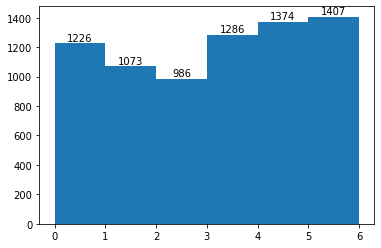

In [40]:
# Class Distribution in training data 
freq, bins, patches = plt.hist(trainY, bins = [0,1,2,3,4,5,6])

# x coordinate for labels
bin_centers = np.diff(bins)*0.5 + bins[:-1]

n = 0
for fr, x, patch in zip(freq, bin_centers, patches):
    height = int(freq[n])
    plt.annotate("{}".format(height),
               xy = (x, height),             # top left corner of the histogram bar
               xytext = (0,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )
    n = n+1
    

The data consists of 9 time varying signals. Each row represents one instance sampled via a fixed-width sliding windows of 2.56 sec with 50% overlap for 128 readings per window. Hence, each row is 128 in length. There are a total of 10,299 samples total. Kaggle initially divided the data into a 70/30 train/test split. I have divided the test data in 1/2 such that there is now a 70/15/15 train/test/dev split. A relatively even class spread is noted between all 6 classes. 

# Visualization

In [121]:
seeTrainX0 = pd.DataFrame(trainX[1100])
print(trainY[1100])

seeTrainX1 = pd.DataFrame(trainX[500])
print(trainY[500])

seeTrainX2 = pd.DataFrame(trainX[300])
print(trainY[300])

seeTrainX3 = pd.DataFrame(trainX[400])
print(trainY[400])

seeTrainX4 = pd.DataFrame(trainX[1])
print(trainY[1])


0
1
2
3
4


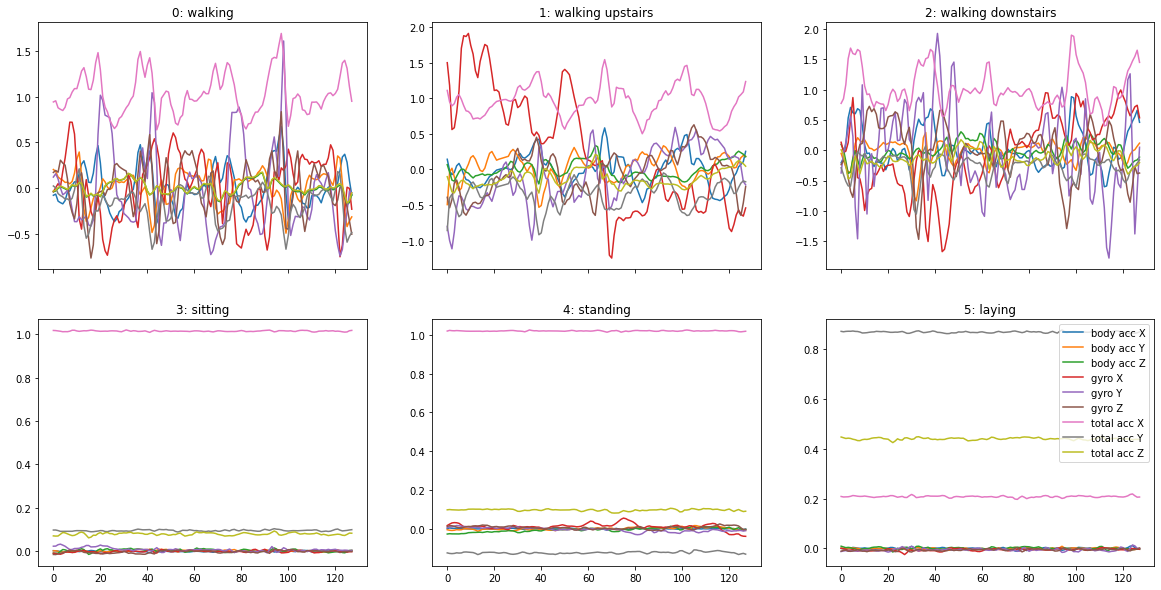

In [231]:
fig, axs = plt.subplots(2, 3, sharex = True, figsize = (20,10))
axs[0,0].set_title('0: walking')
axs[0,0].plot(seeTrainX0[0])
axs[0,0].plot(seeTrainX0[1])
axs[0,0].plot(seeTrainX0[2])
axs[0,0].plot(seeTrainX0[3])
axs[0,0].plot(seeTrainX0[4])
axs[0,0].plot(seeTrainX0[5])
axs[0,0].plot(seeTrainX0[6])
axs[0,0].plot(seeTrainX0[7])
axs[0,0].plot(seeTrainX0[8])

axs[0,1].set_title('1: walking upstairs')
axs[0,1].plot(seeTrainX1[0])
axs[0,1].plot(seeTrainX1[1])
axs[0,1].plot(seeTrainX1[2])
axs[0,1].plot(seeTrainX1[3])
axs[0,1].plot(seeTrainX1[4])
axs[0,1].plot(seeTrainX1[5])
axs[0,1].plot(seeTrainX1[6])
axs[0,1].plot(seeTrainX1[7])
axs[0,1].plot(seeTrainX1[8])

axs[0,2].set_title('2: walking downstairs')
axs[0,2].plot(seeTrainX2[0])
axs[0,2].plot(seeTrainX2[1])
axs[0,2].plot(seeTrainX2[2])
axs[0,2].plot(seeTrainX2[3])
axs[0,2].plot(seeTrainX2[4])
axs[0,2].plot(seeTrainX2[5])
axs[0,2].plot(seeTrainX2[6])
axs[0,2].plot(seeTrainX2[7])
axs[0,2].plot(seeTrainX2[8])

axs[1,0].set_title('3: sitting')
axs[1,0].plot(seeTrainX3[0])
axs[1,0].plot(seeTrainX3[1])
axs[1,0].plot(seeTrainX3[2])
axs[1,0].plot(seeTrainX3[3])
axs[1,0].plot(seeTrainX3[4])
axs[1,0].plot(seeTrainX3[5])
axs[1,0].plot(seeTrainX3[6])
axs[1,0].plot(seeTrainX3[7])
axs[1,0].plot(seeTrainX3[8])

axs[1,1].set_title('4: standing')
axs[1,1].plot(seeTrainX4[0])
axs[1,1].plot(seeTrainX4[1])
axs[1,1].plot(seeTrainX4[2])
axs[1,1].plot(seeTrainX4[3])
axs[1,1].plot(seeTrainX4[4])
axs[1,1].plot(seeTrainX4[5])
axs[1,1].plot(seeTrainX4[6])
axs[1,1].plot(seeTrainX4[7])
axs[1,1].plot(seeTrainX4[8])

axs[1,2].set_title('5: laying')
axs[1,2].plot(seeTrainX5[0], label = 'body acc X')
axs[1,2].plot(seeTrainX5[1], label = 'body acc Y')
axs[1,2].plot(seeTrainX5[2], label = 'body acc Z')
axs[1,2].plot(seeTrainX5[3], label = 'gyro X')
axs[1,2].plot(seeTrainX5[4], label = 'gyro Y')
axs[1,2].plot(seeTrainX5[5], label = 'gyro Z')
axs[1,2].plot(seeTrainX5[6], label = 'total acc X')
axs[1,2].plot(seeTrainX5[7], label = 'total acc Y')
axs[1,2].plot(seeTrainX5[8], label = 'total acc Z')

plt.legend()

plt.show()

Sitting and standing look remarkably similar.

## Normalize each signal between 0 & 1

In [359]:
# Find max and min of each singal in training data
mins = []
maxs = []
for i in range(len(trainX)): 
    mins.append([])
    maxs.append([])
    temp = pd.DataFrame(trainX[i])
    
    for j in range(9):
        mins[i].append(min(temp[j]))
        maxs[i].append(max(temp[j]))


In [361]:
# Find max and min of each singal in testing data
minsTest = []
maxsTest = []
for i in range(len(testX)): 
    minsTest.append([])
    maxsTest.append([])
    temp = pd.DataFrame(testX[i])
    for j in range(9):
        minsTest[i].append(min(temp[j]))
        maxsTest[i].append(max(temp[j]))


In [382]:
# Find each signal's global max and min across train and test data
mins = pd.DataFrame(mins)
maxs = pd.DataFrame(maxs)
minsTest = pd.DataFrame(minsTest)
maxsTest = pd.DataFrame(maxsTest)

minDFs = [mins, minsTest]
mins = pd.concat(minDFs)

maxDFs = [maxs, maxsTest]
maxs = pd.concat(maxDFs)

signalMins = np.zeros([9,1])
signalMaxs = np.zeros([9,1])
ranges = np.zeros([9,1])
for i in range(9):
    signalMins[i] = min(mins[i])
    signalMaxs[i] = max(maxs[i])
    ranges[i] = signalMaxs[i] - signalMins[i]
    


In [414]:
# Normalize each signal
for i in range(trainX.shape[0]):
    for j in range(128):
        for m in range(9):
            trainX[i][j][m] = (trainX[i][j][m] - signalMins[m])/(ranges[m])
            
for i in range(testX.shape[0]):
    for j in range(128):
        for m in range(9):
            testX[i][j][m] = (trainX[i][j][m] - signalMins[m])/(ranges[m])

# The Normalized Signals

In [416]:
seeTrainX0 = pd.DataFrame(trainX[1100])
print(trainY[1100])

seeTrainX1 = pd.DataFrame(trainX[500])
print(trainY[500])

seeTrainX2 = pd.DataFrame(trainX[300])
print(trainY[300])

seeTrainX3 = pd.DataFrame(trainX[400])
print(trainY[400])

seeTrainX4 = pd.DataFrame(trainX[1])
print(trainY[1])


0
1
2
3
4


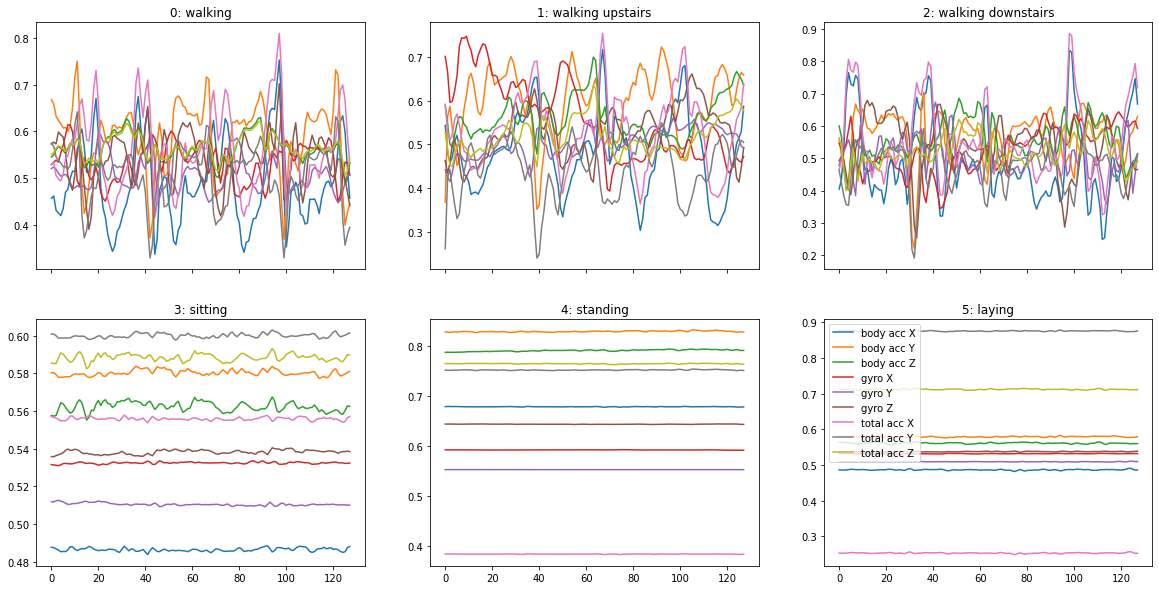

In [417]:
fig, axs = plt.subplots(2, 3, sharex = True, figsize = (20,10))
axs[0,0].set_title('0: walking')
axs[0,0].plot(seeTrainX0[0])
axs[0,0].plot(seeTrainX0[1])
axs[0,0].plot(seeTrainX0[2])
axs[0,0].plot(seeTrainX0[3])
axs[0,0].plot(seeTrainX0[4])
axs[0,0].plot(seeTrainX0[5])
axs[0,0].plot(seeTrainX0[6])
axs[0,0].plot(seeTrainX0[7])
axs[0,0].plot(seeTrainX0[8])

axs[0,1].set_title('1: walking upstairs')
axs[0,1].plot(seeTrainX1[0])
axs[0,1].plot(seeTrainX1[1])
axs[0,1].plot(seeTrainX1[2])
axs[0,1].plot(seeTrainX1[3])
axs[0,1].plot(seeTrainX1[4])
axs[0,1].plot(seeTrainX1[5])
axs[0,1].plot(seeTrainX1[6])
axs[0,1].plot(seeTrainX1[7])
axs[0,1].plot(seeTrainX1[8])

axs[0,2].set_title('2: walking downstairs')
axs[0,2].plot(seeTrainX2[0])
axs[0,2].plot(seeTrainX2[1])
axs[0,2].plot(seeTrainX2[2])
axs[0,2].plot(seeTrainX2[3])
axs[0,2].plot(seeTrainX2[4])
axs[0,2].plot(seeTrainX2[5])
axs[0,2].plot(seeTrainX2[6])
axs[0,2].plot(seeTrainX2[7])
axs[0,2].plot(seeTrainX2[8])

axs[1,0].set_title('3: sitting')
axs[1,0].plot(seeTrainX3[0])
axs[1,0].plot(seeTrainX3[1])
axs[1,0].plot(seeTrainX3[2])
axs[1,0].plot(seeTrainX3[3])
axs[1,0].plot(seeTrainX3[4])
axs[1,0].plot(seeTrainX3[5])
axs[1,0].plot(seeTrainX3[6])
axs[1,0].plot(seeTrainX3[7])
axs[1,0].plot(seeTrainX3[8])

axs[1,1].set_title('4: standing')
axs[1,1].plot(seeTrainX4[0])
axs[1,1].plot(seeTrainX4[1])
axs[1,1].plot(seeTrainX4[2])
axs[1,1].plot(seeTrainX4[3])
axs[1,1].plot(seeTrainX4[4])
axs[1,1].plot(seeTrainX4[5])
axs[1,1].plot(seeTrainX4[6])
axs[1,1].plot(seeTrainX4[7])
axs[1,1].plot(seeTrainX4[8])

axs[1,2].set_title('5: laying')
axs[1,2].plot(seeTrainX5[0], label = 'body acc X')
axs[1,2].plot(seeTrainX5[1], label = 'body acc Y')
axs[1,2].plot(seeTrainX5[2], label = 'body acc Z')
axs[1,2].plot(seeTrainX5[3], label = 'gyro X')
axs[1,2].plot(seeTrainX5[4], label = 'gyro Y')
axs[1,2].plot(seeTrainX5[5], label = 'gyro Z')
axs[1,2].plot(seeTrainX5[6], label = 'total acc X')
axs[1,2].plot(seeTrainX5[7], label = 'total acc Y')
axs[1,2].plot(seeTrainX5[8], label = 'total acc Z')

plt.legend()

plt.show()

In [436]:
# was normalized before dividing test split into test and dev 
testX, devX, testY, devY = train_test_split(testX, testY, test_size = 0.5, random_state = 42)

print('trainX shape is: ', trainX.shape)
print('testX shape is: ', testX.shape)
print('devX shape is: ', devX.shape)

print('trainY shape is: ', trainY.shape)
print('testY shape is: ', testY.shape)
print('devY shape is: ', devY.shape)


trainX shape is:  (7352, 128, 9)
testX shape is:  (1473, 128, 9)
devX shape is:  (1474, 128, 9)
trainY shape is:  (7352,)
testY shape is:  (1473,)
devY shape is:  (1474,)


# Benchmark

(7352, 1152)
(1473, 1152)

Classification Report:

               precision    recall  f1-score   support

           0       0.38      0.21      0.27       254
           1       0.46      0.48      0.47       225
           2       0.42      0.20      0.27       223
           3       0.57      0.76      0.65       235
           4       0.43      0.65      0.52       278
           5       1.00      1.00      1.00       258

    accuracy                           0.56      1473
   macro avg       0.54      0.55      0.53      1473
weighted avg       0.55      0.56      0.54      1473


Confusion Matrix:



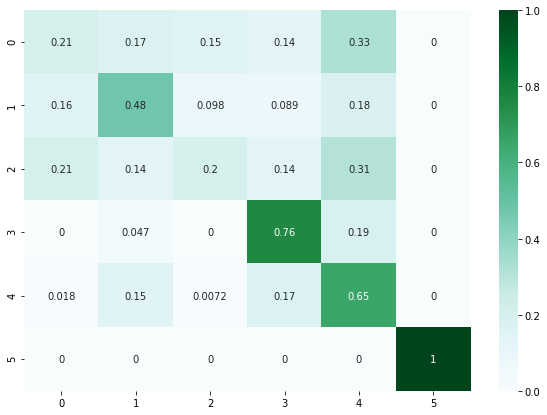

In [437]:
from sklearn.linear_model import LogisticRegression

# Reshape 3D data from (#, 128, 9) to (#, 128*9) or (#, 1152)
benchmarkTrainX = trainX.reshape(trainY.shape[0],1152)
benchmarkTestX = testX.reshape(testY.shape[0],1152)
print(benchmarkTrainX.shape)
print(benchmarkTestX.shape)

# Train & Pred. w/ Log. Reg.  
logReg = LogisticRegression(max_iter=10000)
y_pred = logReg.fit(benchmarkTrainX, trainY).predict(benchmarkTestX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, y_pred))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, y_pred, normalize='true'), cmap='BuGn', annot = True)

# Training: Before Normalization

In [439]:
# let's just start somewhere 
# Build model 
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(SimpleRNN(64)))        # add a fully-connected recurrent layer
model.add(Dense(64, activation = 'relu'))      # add a dense layer
model.add(Dense(6, activation = 'sigmoid'))    # add classifier

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 1, epochs=7,   
                    validation_data = (testX, testY))


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 128)               9472      
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 390       
Total params: 18,118
Trainable params: 18,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
7352/7352 [==============================] - 162s 22ms/step - loss: 1.1718 - accuracy: 0.5067 - val_loss: 1.1672 - val_accuracy: 0.4786
Epoch 2/7
7352/7352 [==============================] - 164s 22ms/step - loss: 0.8954 - accuracy: 0.6238 - val_loss: 1.0294 - val_accuracy: 0.5798
Epoch 3/7
7352/7352 [==============================] - 160s 22ms/step - loss: 0.7755 - 


Classification Report:

               precision    recall  f1-score   support

           0       0.46      0.32      0.38       254
           1       0.57      0.66      0.61       225
           2       0.52      0.62      0.57       223
           3       0.85      0.71      0.78       235
           4       0.74      0.85      0.79       278
           5       0.98      0.98      0.98       258

    accuracy                           0.70      1473
   macro avg       0.69      0.69      0.68      1473
weighted avg       0.69      0.70      0.69      1473


Confusion Matrix:



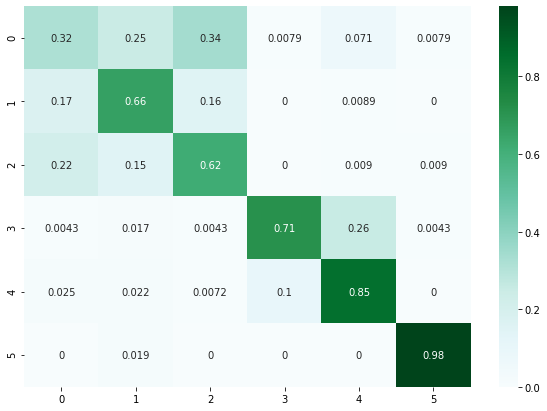

In [440]:
##### Use model to make predictions
preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

Confused walking and walking up and down stairs and sitting and standing. I want to increase bacth size to 32 (it will run faster) and change activation to relu. 

In [441]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
# add a fully-connected recurrent layer
model.add(Bidirectional(SimpleRNN(64)))
# add a dense layer
model.add(Dense(64, activation = 'relu'))
# add classifier
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_02.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 7, 
                    validation_data = (testX, testY), callbacks = [save_best])


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_19 (Bidirectio (None, 128)               9472      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 390       
Total params: 18,118
Trainable params: 18,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
207/207 [==============================] - 8s 36ms/step - loss: 1.3298 - accuracy: 0.4154 - val_loss: 1.3066 - val_accuracy: 0.3995
Epoch 2/7
207/207 [==============================] - 7s 34ms/step - loss: 1.1402 - accuracy: 0.5281 - val_loss: 0.8751 - val_accuracy: 0.6413
Epoch 3/7
207/207 [==============================] - 7s 35ms/step - loss: 0.9976 - accuracy: 0.


Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.82      0.69       254
           1       0.61      0.46      0.52       225
           2       0.76      0.72      0.74       223
           3       0.77      0.81      0.79       235
           4       0.83      0.72      0.77       278
           5       1.00      1.00      1.00       258

    accuracy                           0.76      1473
   macro avg       0.76      0.75      0.75      1473
weighted avg       0.77      0.76      0.76      1473


Confusion Matrix:



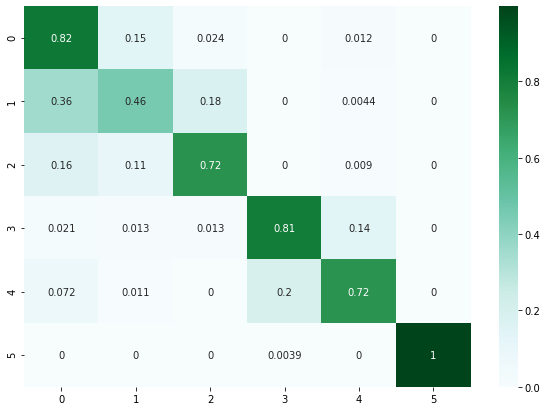

In [442]:
##### Use model to make predictions
model = load_model('model_02.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

Changing activation and increasing batch size resulted in better results. Overfitting is not occuring so lets train this one longer then potentially go bigger with the rnn. 

In [461]:
model = load_model('model_02.h5')

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 20, initial_epoch = 7,
                    validation_data = (testX, testY), callbacks = [save_best])

Epoch 8/20
230/230 [==============================] - 9s 36ms/step - loss: 0.5544 - accuracy: 0.7745 - val_loss: 0.6772 - val_accuracy: 0.7026
Epoch 9/20
230/230 [==============================] - 8s 36ms/step - loss: 0.5562 - accuracy: 0.7700 - val_loss: 0.6195 - val_accuracy: 0.7366
Epoch 10/20
230/230 [==============================] - 8s 35ms/step - loss: 0.6294 - accuracy: 0.7274 - val_loss: 0.6718 - val_accuracy: 0.7115
Epoch 11/20
230/230 [==============================] - 8s 35ms/step - loss: 0.5613 - accuracy: 0.7587 - val_loss: 0.6164 - val_accuracy: 0.7508
Epoch 12/20
230/230 [==============================] - 8s 35ms/step - loss: 0.4829 - accuracy: 0.8059 - val_loss: 0.6135 - val_accuracy: 0.7576
Epoch 13/20
230/230 [==============================] - 9s 38ms/step - loss: 0.4401 - accuracy: 0.8198 - val_loss: 0.6106 - val_accuracy: 0.7583
Epoch 14/20
230/230 [==============================] - 8s 36ms/step - loss: 0.4005 - accuracy: 0.8437 - val_loss: 0.6567 - val_accuracy: 0

Def started to see overfitting. Best model was saved at 17th epoch with train acc and loss of 89% & 0.2909 and a test acc and loss of 86% & 0.4178


Classification Report:

               precision    recall  f1-score   support

           0       0.81      0.86      0.83       254
           1       0.86      0.83      0.85       225
           2       0.81      0.83      0.82       223
           3       0.88      0.75      0.81       235
           4       0.83      0.90      0.86       278
           5       1.00      0.97      0.98       258

    accuracy                           0.86      1473
   macro avg       0.86      0.86      0.86      1473
weighted avg       0.86      0.86      0.86      1473


Confusion Matrix:



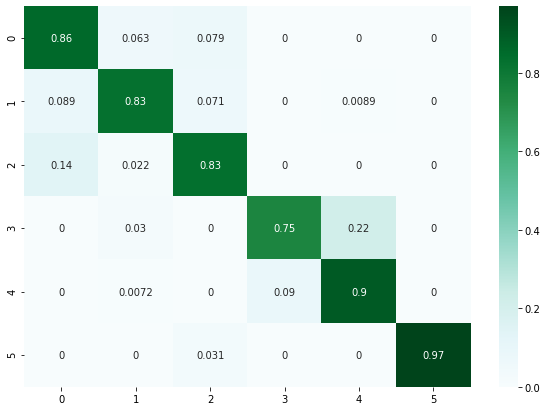

In [462]:
##### Use model to make predictions
model = load_model('model_02Long.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

pretty good. cool

In [443]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(SimpleRNN(128)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_01.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 7, 
                    validation_data = (testX, testY), callbacks = [save_best])


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio (None, 256)               35328     
_________________________________________________________________
dense_40 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 390       
Total params: 52,166
Trainable params: 52,166
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
230/230 [==============================] - 11s 43ms/step - loss: 1.5830 - accuracy: 0.3092 - val_loss: 1.4652 - val_accuracy: 0.3652
Epoch 2/7
230/230 [==============================] - 8s 36ms/step - loss: 1.3307 - accuracy: 0.4040 - val_loss: 1.2538 - val_accuracy: 0.4189
Epoch 3/7
230/230 [==============================] - 8s 37ms/step - loss: 1.2077 - accuracy: 0


Classification Report:

               precision    recall  f1-score   support

           0       0.27      0.48      0.34       254
           1       0.54      0.65      0.59       225
           2       0.51      0.53      0.52       223
           3       0.81      0.77      0.79       235
           4       0.00      0.00      0.00       278
           5       0.87      1.00      0.93       258

    accuracy                           0.56      1473
   macro avg       0.50      0.57      0.53      1473
weighted avg       0.49      0.56      0.52      1473


Confusion Matrix:



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


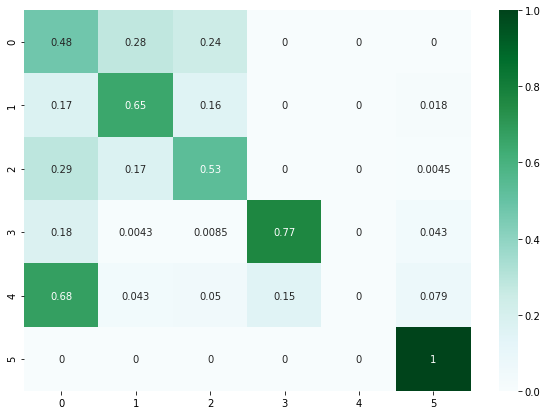

In [444]:
##### Use model to make predictions
model = load_model('model_01.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

Thats odd that it didn't classify anything as standing. Was more confused with the walking types as well. Maybe smaller and more epoch is better? I need to increase epoch bc it doesn't look like the model is done learning at 7 epoch. 

In [447]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
# add a fully-connected recurrent layer
model.add(Bidirectional(SimpleRNN(32)))
# add a dense layer
model.add(Dense(64, activation = 'relu'))
# add classifier
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_03.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 20, 
                    validation_data = (testX, testY), callbacks = [save_best])



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 64)                2688      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 390       
Total params: 7,238
Trainable params: 7,238
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
230/230 [==============================] - 11s 34ms/step - loss: 1.1567 - accuracy: 0.5484 - val_loss: 0.7867 - val_accuracy: 0.6565
Epoch 2/20
230/230 [==============================] - 8s 33ms/step - loss: 0.7154 - accuracy: 0.6987 - val_loss: 0.7691 - val_accuracy: 0.6646
Epoch 3/20
230/230 [==============================] - 8s 33ms/step - loss: 0.5858 - accuracy: 

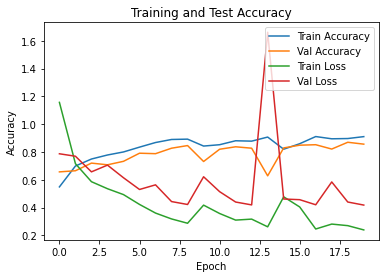

In [448]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')

Perhaps it could train even longer 


Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.83      0.85       254
           1       0.81      0.81      0.81       225
           2       0.89      0.96      0.92       223
           3       0.75      0.80      0.77       235
           4       0.82      0.78      0.80       278
           5       1.00      0.97      0.98       258

    accuracy                           0.86      1473
   macro avg       0.86      0.86      0.86      1473
weighted avg       0.86      0.86      0.86      1473


Confusion Matrix:



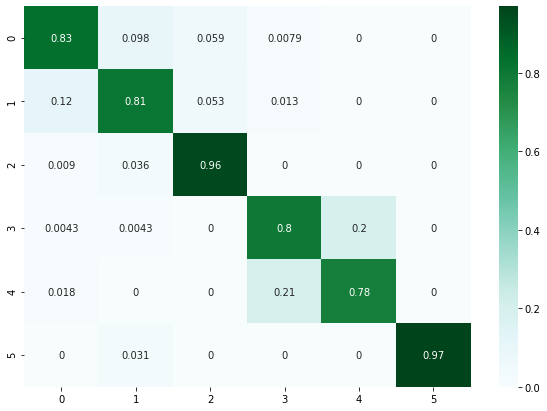

In [449]:
##### Use model to make predictions
model = load_model('model_03.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

I want to go smaller just to go smaller and see if it still works ok

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_23 (Bidirectio (None, 32)                832       
_________________________________________________________________
dense_46 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 198       
Total params: 2,086
Trainable params: 2,086
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
196/196 [==============================] - 8s 33ms/step - loss: 1.3958 - accuracy: 0.4484 - val_loss: 1.2827 - val_accuracy: 0.4488
Epoch 2/30
196/196 [==============================] - 6s 32ms/step - loss: 1.2256 - accuracy: 0.5062 - val_loss: 1.2498 - val_accuracy: 0.5059
Epoch 3/30
196/196 [==============================] - 6s 32ms/step - loss: 1.1264 - accuracy: 0

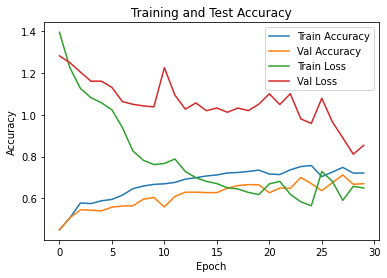

In [450]:
 # Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
# add a fully-connected recurrent layer
model.add(Bidirectional(SimpleRNN(16)))
# add a dense layer
model.add(Dense(32, activation = 'relu'))
# add classifier
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('model_05.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 30, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')


Classification Report:

               precision    recall  f1-score   support

           0       0.38      0.73      0.50       254
           1       0.57      0.69      0.62       225
           2       0.80      0.69      0.74       223
           3       0.73      0.87      0.80       235
           4       0.00      0.00      0.00       278
           5       0.99      0.91      0.95       258

    accuracy                           0.64      1473
   macro avg       0.58      0.65      0.60      1473
weighted avg       0.56      0.64      0.59      1473


Confusion Matrix:



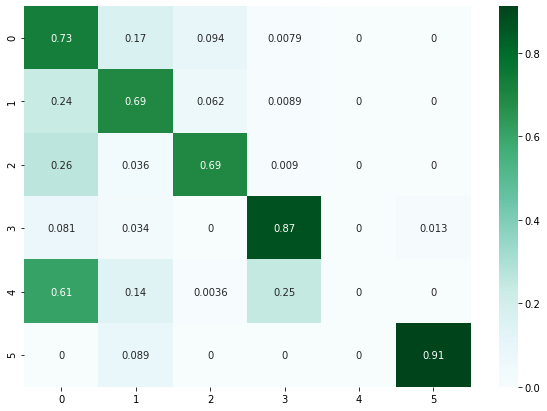

In [451]:
##### Use model to make predictions
model = load_model('model_05.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, preds))
print('\nConfusion Matrix:\n')
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

This model was probably too small

# Train LSTM

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 32)                3328      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 198       
Total params: 4,582
Trainable params: 4,582
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 15s 49ms/step - loss: 1.4104 - accuracy: 0.4322 - val_loss: 1.2298 - val_accuracy: 0.5131
Epoch 2/15
196/196 [==============================] - 9s 46ms/step - loss: 1.0785 - accuracy: 0.5745 - val_loss: 1.1004 - val_accuracy: 0.5902
Epoch 3/15
196/196 [==============================] - 10s 49ms/step - loss: 0.9228 - accuracy:

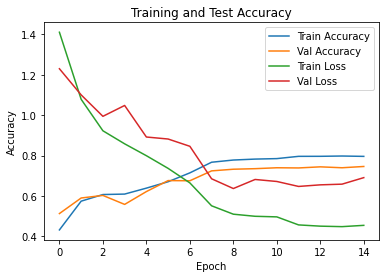

In [178]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set)  
save_best = tf.keras.callbacks.ModelCheckpoint('LSTM_model_01.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 15, 
                    validation_split = 0.15, callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')


Classification Report:

               precision    recall  f1-score   support

           0       0.47      0.87      0.62       496
           1       0.79      0.87      0.83       471
           2       0.82      0.90      0.86       420
           3       0.77      0.85      0.81       491
           4       0.00      0.00      0.00       532
           5       1.00      0.95      0.97       537

    accuracy                           0.73      2947
   macro avg       0.64      0.74      0.68      2947
weighted avg       0.63      0.73      0.67      2947



[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

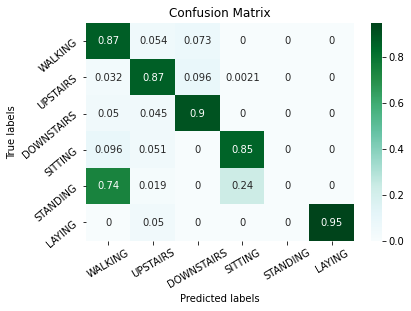

In [183]:
##### Use model to make predictions
model = load_model('LSTM_model_01.h5')

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, 64)                10752     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 198       
Total params: 13,030
Trainable params: 13,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 12s 50ms/step - loss: 1.0799 - accuracy: 0.5748 - val_loss: 0.8105 - val_accuracy: 0.6682
Epoch 2/15
196/196 [==============================] - 9s 48ms/step - loss: 0.6356 - accuracy: 0.7396 - val_loss: 0.7982 - val_accuracy: 0.6528
Epoch 3/15
196/196 [==============================] - 9s 47ms/step - loss: 0.6576 - accuracy

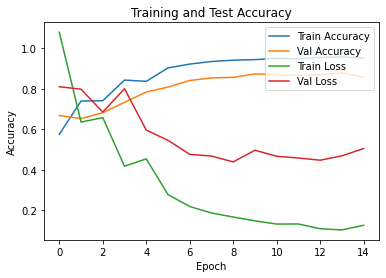

In [184]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'LSTM_model_01.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 15, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')


Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.94      0.93       496
           1       0.90      0.87      0.88       471
           2       0.84      0.95      0.89       420
           3       0.85      0.78      0.81       491
           4       0.81      0.86      0.83       532
           5       1.00      0.92      0.96       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

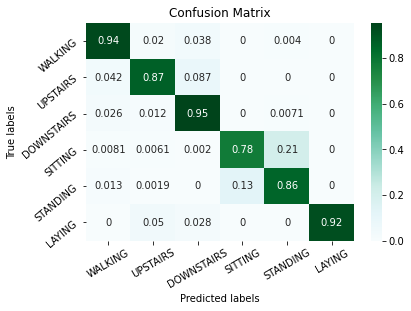

In [185]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

Increasing LSTM size helped a lot. Now the most confusion occurs btwn sitting and standing. This confusion is likely a result of the signals being quite similar. I haven't normalized the signals any yet due to them not ranging a great deal. The largest value in a signal is less tha 6 and the greatest range for a given signal is less than 12. So let us normalize the signals and see if that helps. 

# Training: Normalized Between 0 & 1

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 64)                10752     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 6)                 198       
Total params: 13,030
Trainable params: 13,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 13s 52ms/step - loss: 1.7066 - accuracy: 0.2370 - val_loss: 1.5285 - val_accuracy: 0.3545
Epoch 2/15
196/196 [==============================] - 11s 54ms/step - loss: 1.4772 - accuracy: 0.3588 - val_loss: 1.4662 - val_accuracy: 0.3382
Epoch 3/15
196/196 [==============================] - 11s 54ms/step - loss: 1.4807 - accura

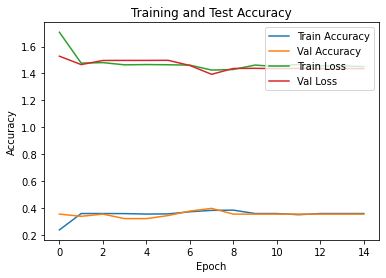

In [423]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'norm_LSTM_model_02.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 15, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')


Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       496
           1       0.00      0.00      0.00       471
           2       0.00      0.00      0.00       420
           3       0.00      0.00      0.00       491
           4       0.00      0.00      0.00       532
           5       0.18      1.00      0.31       537

    accuracy                           0.18      2947
   macro avg       0.03      0.17      0.05      2947
weighted avg       0.03      0.18      0.06      2947



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

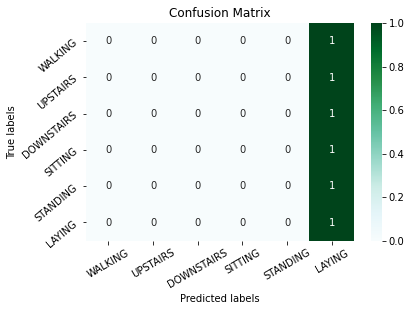

In [424]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

Welp. That did not help. 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 64)                10752     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 390       
Total params: 15,302
Trainable params: 15,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 13s 53ms/step - loss: 1.5423 - accuracy: 0.3377 - val_loss: 1.5034 - val_accuracy: 0.3209
Epoch 2/15
196/196 [==============================] - 12s 61ms/step - loss: 1.4816 - accuracy: 0.3495 - val_loss: 1.4894 - val_accuracy: 0.3545
Epoch 3/15
196/196 [==============================] - 11s 54ms/step - loss: 1.4449 - accura

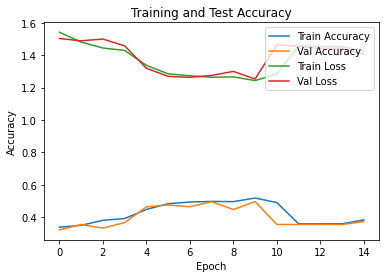

In [425]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'norm_LSTM_model_02.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 15, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')

It tried to learn, then it failed 


Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       496
           1       0.00      0.00      0.00       471
           2       0.00      0.00      0.00       420
           3       0.17      0.66      0.27       491
           4       0.00      0.00      0.00       532
           5       0.21      0.42      0.28       537

    accuracy                           0.19      2947
   macro avg       0.06      0.18      0.09      2947
weighted avg       0.07      0.19      0.10      2947



[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

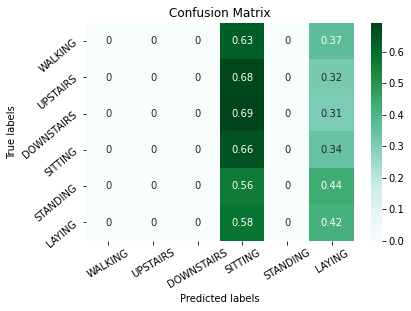

In [426]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

oh pooey. Let us not normalize the data btwn 0 and 1. A different form of normalization may be beneficial, but I'm getting good results with the raw data so perhaps normalization is not needed? 

# Back to NO NORMALIZATION
* Normalizing the data did not help 

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 128)               37888     
_________________________________________________________________
dense_54 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_55 (Dense)             (None, 6)                 198       
Total params: 42,214
Trainable params: 42,214
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
230/230 [==============================] - 19s 59ms/step - loss: 1.2526 - accuracy: 0.5215 - val_loss: 1.1245 - val_accuracy: 0.5662
Epoch 2/15
230/230 [==============================] - 13s 56ms/step - loss: 0.8918 - accuracy: 0.6506 - val_loss: 0.9227 - val_accuracy: 0.6755
Epoch 3/15
230/230 [==============================] - 13s 59ms/step - loss: 0.6850 - accura

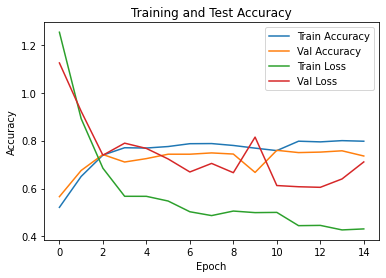

In [467]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'LSTM_model_02.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 15, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')


Classification Report:

               precision    recall  f1-score   support

           0       0.49      0.91      0.64       254
           1       0.86      0.93      0.90       225
           2       0.91      0.93      0.92       223
           3       0.74      0.86      0.79       235
           4       0.00      0.00      0.00       278
           5       1.00      1.00      1.00       258

    accuracy                           0.75      1473
   macro avg       0.67      0.77      0.71      1473
weighted avg       0.65      0.75      0.69      1473



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

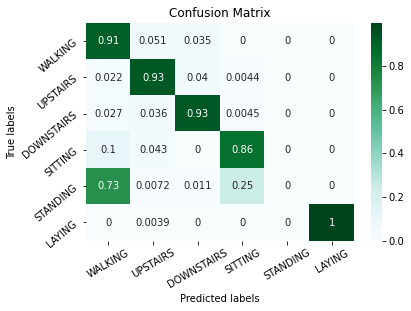

In [468]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

I'm not sure why it struggles with standing in this manner so much. 

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_28 (Bidirectio (None, 128)               37888     
_________________________________________________________________
dense_56 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 6)                 198       
Total params: 42,214
Trainable params: 42,214
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
115/115 [==============================] - 12s 81ms/step - loss: 1.4216 - accuracy: 0.4197 - val_loss: 1.2126 - val_accuracy: 0.4942
Epoch 2/10
115/115 [==============================] - 9s 75ms/step - loss: 0.9876 - accuracy: 0.6186 - 

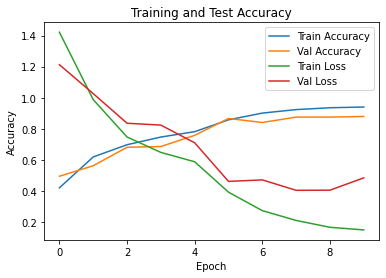

In [469]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'LSTM_model_02.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 64, epochs = 10, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')

In [471]:
##### run longer
history = model.fit(trainX, trainY, batch_size = 64, epochs = 20, initial_epoch = 10,
                    validation_data = (testX, testY), callbacks = [save_best])

Epoch 11/20
115/115 [==============================] - 11s 78ms/step - loss: 0.1681 - accuracy: 0.9395 - val_loss: 0.5944 - val_accuracy: 0.8330
Epoch 12/20
115/115 [==============================] - 8s 73ms/step - loss: 0.1768 - accuracy: 0.9312 - val_loss: 0.4177 - val_accuracy: 0.8751
Epoch 13/20
115/115 [==============================] - 10s 86ms/step - loss: 0.1576 - accuracy: 0.9400 - val_loss: 0.4205 - val_accuracy: 0.8893
Epoch 14/20
115/115 [==============================] - 9s 79ms/step - loss: 0.1420 - accuracy: 0.9449 - val_loss: 0.4155 - val_accuracy: 0.8941
Epoch 15/20
115/115 [==============================] - 9s 80ms/step - loss: 0.1606 - accuracy: 0.9373 - val_loss: 0.3708 - val_accuracy: 0.8805
Epoch 16/20
115/115 [==============================] - 9s 80ms/step - loss: 0.1554 - accuracy: 0.9415 - val_loss: 0.3314 - val_accuracy: 0.8866
Epoch 17/20
115/115 [==============================] - 9s 79ms/step - loss: 0.1566 - accuracy: 0.9421 - val_loss: 0.4371 - val_accurac

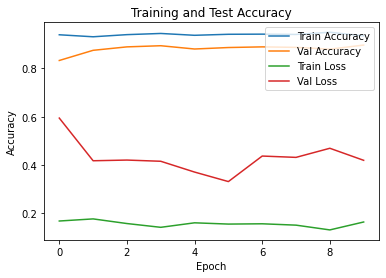

In [472]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')

Ran longere bc I wanted to see if after 10 epoch if the testing loss would continue to increase or it just happened to end on a higher loss. Testing loss was able to decrease to a bit more, but training loss plateued at 0.15 ish with an accuracy of 93% ish (testing accuracy was 89%, suggesting slight overfitting). 


Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.93      0.93       254
           1       0.84      0.88      0.86       225
           2       0.89      0.91      0.90       223
           3       0.83      0.81      0.82       235
           4       0.84      0.85      0.85       278
           5       1.00      0.94      0.97       258

    accuracy                           0.89      1473
   macro avg       0.89      0.89      0.89      1473
weighted avg       0.89      0.89      0.89      1473



[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

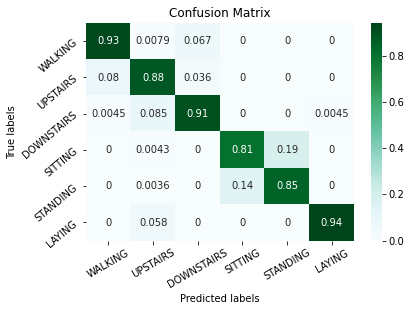

In [473]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

Still struggling with confusing sitting and standing. That is where the majority of the error is coming from. I wonder if any regularization will help. 

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_31 (Bidirectio (None, 64)                10752     
_________________________________________________________________
dense_62 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 6)                 198       
Total params: 13,030
Trainable params: 13,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
230/230 [==============================] - 14s 49ms/step - loss: 1.0524 - accuracy: 0.5824 - val_loss: 0.8299 - val_accuracy: 0.6762
Epoch 2/50
230/230 [==============================] - 11s 46ms/step - loss: 0.6874 - accuracy: 0.7130 -

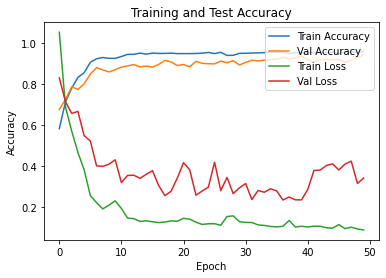

In [476]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'LSTM_model_03.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False)  

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 50, 
                    validation_data = (testX, testY), callbacks = [save_best])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')

Best model occurred at epoch # 37

With the increase in loss around the 40th epoch, I wonder if the data was memorized at that point. However, it's interesting that the increase in testing loss is not reflected in a testing acc, as testing acc seems to be increasing despite the loss. 


Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.98      0.98       254
           1       0.98      0.94      0.96       225
           2       0.95      1.00      0.97       223
           3       0.82      0.82      0.82       235
           4       0.85      0.85      0.85       278
           5       1.00      1.00      1.00       258

    accuracy                           0.93      1473
   macro avg       0.93      0.93      0.93      1473
weighted avg       0.93      0.93      0.93      1473



[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

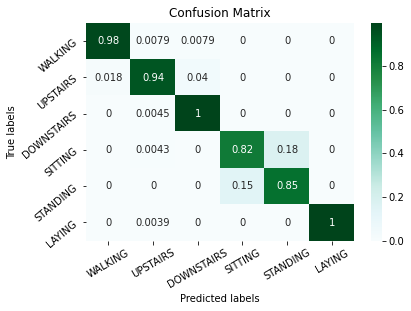

In [477]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

All classes are doing pretty good. Still confusing sitting and standing a decent amount. I wonder if there is a lot of overlap between the signals. When plotted above they appeared quite similar to the naked eye. This follows given that when sitting and standing ther should be little change in accelerations and angular velocity, as one should be still. When classifying HAR in real time they could probably be distguished by the action of standing up vs the action of sitting down rather than idly doing either. I also wonder if the addition of a CNN for feature extraction prior might prove beneficial in differentiting between the classes. Given that the signals appear quite similar, similar features may also be extracted from each, so once again I don't know if that will work either. 

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_32 (Bidirectio (None, 64)                10752     
_________________________________________________________________
dense_64 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 6)                 198       
Total params: 13,030
Trainable params: 13,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
230/230 [==============================] - 14s 49ms/step - loss: 1.0922 - accuracy: 0.5718 - val_loss: 0.7695 - val_accuracy: 0.7033
Epoch 2/50
230/230 [==============================] - 11s 46ms/step - loss: 0.7368 - accuracy: 0.7013 -

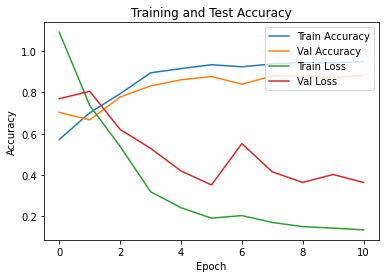

In [478]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'LSTM_model_04.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False) 

# Reduce learning rate when a metric has stopped improving
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 1)  

# Early stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience = 5, verbose = 1) 

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 50, 
                    validation_data = (testX, testY), callbacks = [save_best, lr, es])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_36 (Bidirectio (None, 64)                10752     
_________________________________________________________________
dense_73 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_74 (Dense)             (None, 6)                 198       
Total params: 13,030
Trainable params: 13,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
230/230 [==============================] - 14s 49ms/step - loss: 1.1172 - accuracy: 0.6119 - val_loss: 0.8540 - val_accuracy: 0.6796
Epoch 2/50
230/230 [==============================] - 11s 46ms/step - loss: 0.6164 - accuracy: 0.7927 - val_loss: 0.6660 - val_accuracy: 0.7787
Epoch 3/50
230/230 [==============================] - 11s 48ms/step - loss: 0.4497 - accura

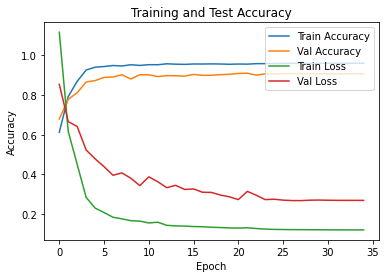

In [487]:
# Build
model = Sequential()
model.add(Input(shape = (trainX.shape[1],trainX.shape[2])))
model.add(Bidirectional(LSTM(32, activity_regularizer = regularizers.L2(0.01))))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(6, activation = 'relu'))

# Model Summary 
model.summary()

##### Compile the model
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Saves the best version of the model to disk (as measured on the validation data set) 
SAVED = 'LSTM_model_05.h5'
save_best = tf.keras.callbacks.ModelCheckpoint(SAVED, monitor = 'val_loss', save_best_only = True, mode = 'min', save_weights_only = False) 

# Reduce learning rate when a metric has stopped improving
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 1)  

# Early stopping (stops training when validation doesn't improve for {patience} epochs)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience = 7, verbose = 1) 

##### Fit the model on the dataset
history = model.fit(trainX, trainY, batch_size = 32, epochs = 50, 
                    validation_data = (testX, testY), callbacks = [save_best, lr, es])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Test Accuracy")
plt.legend(loc = 'upper right')


Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.94      0.96       254
           1       0.88      0.96      0.92       225
           2       0.94      1.00      0.97       223
           3       0.80      0.78      0.79       235
           4       0.85      0.83      0.84       278
           5       1.00      0.94      0.97       258

    accuracy                           0.91      1473
   macro avg       0.91      0.91      0.91      1473
weighted avg       0.91      0.91      0.91      1473



[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'UPSTAIRS'),
 Text(0, 2.5, 'DOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

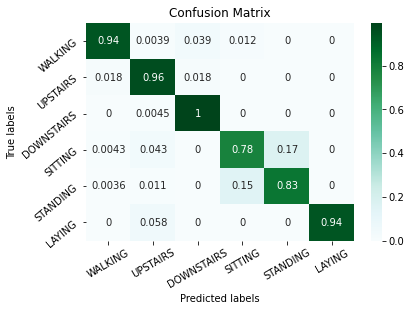

In [488]:
##### Use model to make predictions
model = load_model(SAVED)

preds = model.predict(testX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(testY, preds))

ax= plt.subplot()
sn.heatmap(confusion_matrix(testY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)

I tried various regularizations and dropouts in attempt to reduce the diffence between the training and testing losses, but in the end it did not help in differentiating btwn sitting and standing. 

# Dev Set Evaluation 
* Best model: **LSTM_model_03** 
* Model 3 has a higher testing set accuracy and lower testing loss
* LSTM_model_05 is a close second



Classification Report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       242
           1       1.00      0.93      0.96       246
           2       0.93      1.00      0.97       197
           3       0.82      0.79      0.80       256
           4       0.80      0.82      0.81       254
           5       1.00      1.00      1.00       279

    accuracy                           0.92      1474
   macro avg       0.92      0.92      0.92      1474
weighted avg       0.92      0.92      0.92      1474



<Figure size 720x720 with 0 Axes>

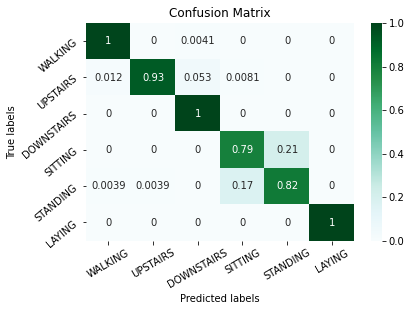

<Figure size 720x720 with 0 Axes>

In [496]:
# Load model
the_chosen_one = load_model('LSTM_model_03.h5')

preds = the_chosen_one.predict(devX)
preds = preds.argmax(axis=1)

print('\nClassification Report:\n\n', classification_report(devY, preds))

ax = plt.subplot()
sn.heatmap(confusion_matrix(devY, preds, normalize='true'), cmap='BuGn', annot = True)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=30)
ax.yaxis.set_ticklabels(['WALKING', 'UPSTAIRS', 'DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], rotation=40)


Did worse in that it confused sitting and standing slightly more. Overall accuracy only decrease by 1%. Translates well to data it has never seen before. 

# The End 